In [1]:
import numpy as np
import pandas as pd 
import uniprot_util
import seaborn as sns

from Bio.SeqUtils import molecular_weight
from Bio import SeqIO
from collections import Counter
from matplotlib import pyplot as plt
from os import path
from tqdm import tqdm

from seq_util import calc_protein_nosc

# Preprocessing reference proteomes (coding sequences)
Reference proteomes from UniProt give the amino acid coding sequences of protein coding genes in many genomes. Here I am parsing the XML reference proteomes used in various mass spec proteomics studies (E. coli, yeast, cyanobacteria, etc.) to gather sequence information (sequence, carbon count, nominal oxidation state of carbon) and metadata (IDs, functional tags). 

See uniprot_util.py for parsing code. 

Note that we are parsing the E. coli b numbers (gene identifiers) from the reference proteome XML since the E. coli data from the Bellevue & Chure paper uses these identifiers. 

In [2]:
# List of the reference proteomes to parse
ref_prot_metadata = pd.read_csv('../data/genomes/reference_proteomes.csv', index_col=0)
ref_prot_metadata.head()

,species,strain,refseq_id,ref_proteome_fname,extract_b_num,CDS_NOSC_csv_fname,KEGG_pathways_fname,KEGG_pathway_mapping_fname
key,,,,,,,,
coli,E. coli,MG1655 K12,UP000000625,data/genomes/Coli/MG1655/UP000000625_83333.xml.gz,True,data/genomes/Coli/MG1655/MG1655_ref_prot_NOSC.csv,data/genomes/Coli/KEGG_pathways.tsv,data/genomes/Coli/KEGG_pathway_mapping.tsv
yeast,S. cerevisiae,S288c,UP000002311,data/genomes/Scer/S288c/UP000002311_559292.xml.gz,False,data/genomes/Scer/S288c/S288c_ref_prot_NOSC.csv,data/genomes/Scer/KEGG_pathways.tsv,data/genomes/Scer/KEGG_pathway_mapping.tsv
PCC6803,Synechocystis sp.,PCC6803,UP000001425,data/genomes/Synechocystis/PCC6803/UP000001425...,False,data/genomes/Synechocystis/PCC6803/PCC6803_ref...,data/genomes/Synechocystis/KEGG_pathways.tsv,data/genomes/Synechocystis/KEGG_pathway_mappin...


In [3]:
# Load amino acid NOSC table -- used to calculate protein NOSC values
aa_nosc_df = pd.read_csv('../data/aa_nosc.csv').set_index('letter_code')
aa_nosc_df.head()

,full_name,short_name,NC,Formula,NOSC,MW,polar_requirement,hydropathy,molecular_volume,isoelectric_point
letter_code,,,,,,,,,,
A,Alanine,ala,3,C3H7NO2,0.00,89.0935,7.0,1.8,31.0,6.00
R,Arginine,arg,6,C6H15N4O2+,0.33,174.2017,9.1,-4.5,124.0,10.76
N,Asparagine,asn,4,C4H8N2O3,1.00,132.1184,10.0,-3.5,56.0,5.41
D,Aspartate,asp,4,C4H6NO4−,1.00,133.1032,13.0,-3.5,54.0,2.77
C,Cysteine,cys,3,C3H7NO2S,0.67,121.1590,4.8,2.5,55.0,5.07


In [4]:
cds_dfs = {}
isoform_fname = '../data/genomes/uniprot_sprot_varsplic.fasta'

# Iterate over the reference proteomes and extract coding sequences and metadata
for idx, row in tqdm(ref_prot_metadata.iterrows()):
    print(idx)
    fpath = path.join('../', row.ref_proteome_fname)
    # Only gets the dominant isoform sequences & metadata
    my_df = uniprot_util.uniprot_xml2df(fpath, extract_b_number=row.extract_b_num)
    
    # Adds entries and sequences for the secondary isoforms
    my_df = uniprot_util.add_isoforms2df(my_df, isoform_fname)
    
    # Load KEGG pathway mappings for genes
    kegg_mapping_fname = path.join('../', row.KEGG_pathway_mapping_fname) 
    kegg_pathways_fname = path.join('../', row.KEGG_pathways_fname)
    uniprot_util.add_KEGGpathways2df(my_df, kegg_mapping_fname, kegg_pathways_fname)
    
    # Add NOSC + species information.
    # Important to add NOSC information after adding the isoforms so that they are calc'd 
    # from the secondary isoform sequences and not the dominant form.
    new_cols = my_df.aa_seq.apply(calc_protein_nosc, args=(aa_nosc_df,)).apply(pd.Series)
    new_cols.columns = 'Ce,NC'.split(',')
    my_df = my_df.merge(new_cols, left_index=True, right_index=True)
    my_df['NOSC'] = my_df.Ce / my_df.NC
    my_df['eC_ratio'] = 4 - my_df.NOSC
    my_df['organism'] = idx
    
    # Make sure we have unique b-numbers for E. coli
    if row.extract_b_num:
        count_bs = pd.Series(Counter(my_df.b_number.values))
        mask = count_bs > 1
        if mask.any():
            print('Found duplicate b-numbers:')
            print(count_bs[mask])
            print('Dropping these')
            
            # Dropping the duplicates because there is just one duplicate b number 
            # and it is found in none of the E. coli expression datasets anyway.
            todrop = my_df.b_number.isin(count_bs[mask].index.values)
            my_df = my_df.drop(my_df.loc[todrop].index, axis=0)
            
    # Store in memory for later cells if needed
    cds_dfs[idx] = my_df
    
    # Save as CSV
    out_fname = path.join('../', row.CDS_NOSC_csv_fname)
    my_df.to_csv(out_fname, index=False)

0it [00:00, ?it/s]

coli
Unknown or non-specific AAs: {'X'}
Unknown or non-specific AAs: {'X'}
Unknown or non-specific AAs: {'X'}
Unknown or non-specific AAs: {'X'}
Unknown or non-specific AAs: {'X'}
Unknown or non-specific AAs: {'X'}
Unknown or non-specific AAs: {'X'}
Unknown or non-specific AAs: {'X'}
Unknown or non-specific AAs: {'X'}
Unknown or non-specific AAs: {'X'}
Unknown or non-specific AAs: {'X'}
Unknown or non-specific AAs: {'X'}
Unknown or non-specific AAs: {'X'}
Unknown or non-specific AAs: {'X'}


1it [00:20, 20.12s/it]

Found duplicate b-numbers:
b4581     2
NaN      12
dtype: int64
Dropping these
yeast


2it [00:45, 21.64s/it]

PCC6803
Unknown or non-specific AAs: {'X'}
Unknown or non-specific AAs: {'X'}


3it [00:56, 18.82s/it]


In [5]:
# Load COG IDs and functional categories
cog_ids = pd.read_csv('../data/COG-20.def.tab.txt', sep='\t', encoding='cp1252', header=None)
cog_ids.columns = 'COG_ID,categories,name,gene,pathway,PubMed_IDs,PDB_ID'.split(',')
cog_ids = cog_ids.set_index('COG_ID')

cog_func = pd.read_csv('../data/COG-fun-20.tab.txt', sep='\t', header=None)
cog_func.columns = 'category,color,description'.split(',')
cog_func = cog_func.set_index('category')

cog_func.to_csv('../data/COG-fun-20.csv', index=True)
cog_ids.to_csv('../data/COG-20.def.csv', index=True)

In [6]:
cds_dfs['coli'].columns

Index(['aa_seq', 'num_aas', 'mw_daltons', 'transmembrane_aas',
       'transmembrane_Cs', 'fraction_transmembrane',
       'fraction_transmembrane_C', 'primary_accession', 'accessions',
       'gene_name', 'description', 'locus_tags', 'GO_terms', 'COG_IDs',
       'KEGG_IDs', 'isoform_accessions', 'b_number', 'KEGG_path_IDs',
       'KEGG_pathways', 'Ce', 'NC', 'NOSC', 'eC_ratio', 'organism'],
      dtype='object')

In [7]:
cols = ['aa_seq', 'num_aas', 'NC', 'Ce', 'NOSC', 'mw_daltons',
       'transmembrane_aas', 'transmembrane_Cs', 'fraction_transmembrane',
       'fraction_transmembrane_C', 'primary_accession', 'accessions',
       'gene_name', 'description', 'locus_tags', 'GO_terms', 'COG_IDs',
       'KEGG_IDs', 'isoform_accessions', 'KEGG_path_IDs',
       'KEGG_pathways', 'eC_ratio', 'organism']

# needs a new index so as not to repeat
long_nosc_df = pd.concat([df.reset_index()[cols] for key, df in cds_dfs.items()]).reset_index().drop(
    'index',axis=1).set_index('primary_accession')

# add b_number back in for later cross-referencing
coli_tmp = cds_dfs['coli'].set_index('primary_accession')
long_nosc_df['b_number'] = None
long_nosc_df.loc[coli_tmp.index, 'b_number'] = coli_tmp.b_number
long_nosc_df = long_nosc_df.reset_index()

# Add columns for COG categories.
# Using the first listed COG ID to retrieve categorial information.
cog_class_dict = dict(primary_COG_category=[], secondary_COG_category=[])
for idx, row in tqdm(long_nosc_df.iterrows()):
    COGs = row.COG_IDs.split(',')
    prim, sec = '', ''
    for c in COGs:
        if c in cog_ids.index:
            cats = cog_ids.loc[c].categories
            prim = cats[0]
            if len(cats) > 1:
                sec = cats[1]
            break
    cog_class_dict['primary_COG_category'].append(prim)
    cog_class_dict['secondary_COG_category'].append(sec)
for l, col in cog_class_dict.items():
    long_nosc_df[l] = col

long_nosc_df.infer_objects()
long_nosc_df.to_csv('../data/genomes/all_ref_prot_NOSC.csv', index=False)
long_nosc_df.head()

13992it [00:01, 13194.78it/s]


,primary_accession,aa_seq,num_aas,NC,Ce,NOSC,mw_daltons,transmembrane_aas,transmembrane_Cs,fraction_transmembrane,...,COG_IDs,KEGG_IDs,isoform_accessions,KEGG_path_IDs,KEGG_pathways,eC_ratio,organism,b_number,primary_COG_category,secondary_COG_category
0,A5A605,MRLHVKLKEFLSMFFMAILFFPAFNASLFFTGVKPLYSIIKCSTEI...,159,862.0,-301.25,-0.349478,18118.0,60.0,345.0,0.377358,...,ENOG5031M8I,eco:b4586,,,,4.349478,coli,b4586,,
1,P02929,MTLDLPRRFPWPTLLSVCIHGAVVAGLLYTSVHQVIELPAPAQPIS...,239,1173.0,-244.16,-0.208150,26094.0,31.0,159.0,0.129707,...,COG0810,"ecj:JW5195,eco:b1252",,,,4.208150,coli,b1252,M,
2,P05523,MPELPEVETSRRGIEPHLVGATILHAVVRNGRLRWPVSEEIYRLSD...,269,1358.0,-231.79,-0.170685,30290.0,0.0,0.0,0.000000,...,COG0266,"ecj:JW3610,eco:b3635",,path:eco03410,Base excision repair - Escherichia coli K-12 M...,4.170685,coli,b3635,L,
3,P06611,MSIVMQLQDVAESTRLGPLSGEVRAGEILHLVGPNGAGKSTLLARM...,249,1189.0,-157.82,-0.132733,27081.0,0.0,0.0,0.000000,...,COG4138,"ecj:JW1699,eco:b1709",,path:eco02010,ABC transporters - Escherichia coli K-12 MG1655,4.132733,coli,b1709,H,
4,P07109,MSENKLNVIDLHKRYGEHEVLKGVSLQANAGDVISIIGSSGSGKST...,257,1266.0,-201.82,-0.159415,28653.0,0.0,0.0,0.000000,...,COG4598,"ecj:JW2303,eco:b2306",,path:eco02010,ABC transporters - Escherichia coli K-12 MG1655,4.159415,coli,b2306,E,


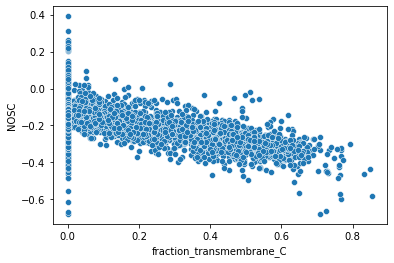

In [8]:
# Transmembrane fraction against NOSC. fraction_transmembrane < 0 indicates a parse error
# There is currently only one such example, a yeast protein
mask = long_nosc_df.fraction_transmembrane >= 0 
sns.scatterplot(data=long_nosc_df[mask], x='fraction_transmembrane_C', y='NOSC')
plt.savefig('../output/tm_proteins_redox.png', facecolor='w', dpi=300)